In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import xarray
plt.style.use("bmh")

import gnss_tid.synthetic
import gnss_tid.parameter

center = xarray.DataArray([100, 100], dims=["ci"])
wavelength = 300.0
phase_speed = 200.0
period = wavelength * 1000 / (60 * phase_speed)
print(period)

data = gnss_tid.synthetic.constant_model(
    center=xarray.DataArray([0, 0], dims=["ci"]),
    wavelength=wavelength,
    phase_speed=phase_speed,
    xlim=(-1500, 1500),
    ylim=(-1500, 1500),
    snr=-3,
    hres=20,
)
data["image"] = data["image"].rolling(x=3, y=3, center=True, min_periods=1).median()

# data = xarray.open_dataset("outputs/2024-12-06/22-20-41/autofocus.h5")

params, patches = gnss_tid.parameter.estimate_parameters_block_v2(data, Nfft=128, use_threshold=False)
params2 = gnss_tid.parameter.estimate_parameters_block_v4(data, 128)

/homes/starrgw1/code/gnss-tid/src/gnss_tid/plotting.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm import autonotebook


25.0
snr = -3, noise_factor = np.float64(0.998814876483345)


In [40]:
patches

<xarray.Dataset> Size: 11GB
Dimensions:  (px: 15, py: 15, time: 121, kx: 128, ky: 128)
Coordinates:
  * px       (px) int64 120B -1180 -1020 -860 -700 -540 ... 420 580 740 900 1060
  * py       (py) int64 120B -1180 -1020 -860 -700 -540 ... 420 580 740 900 1060
  * time     (time) datetime64[ns] 968B 2025-01-01 ... 2025-01-01T02:00:00
  * kx       (kx) float64 1kB 0.0 0.0003906 0.0007813 ... -0.0007813 -0.0003906
  * ky       (ky) float64 1kB 0.0 0.0003906 0.0007813 ... -0.0007813 -0.0003906
Data variables:
    image    (px, py, time, ky, kx) float64 4GB 0.001347 0.002068 ... 0.0 0.0
    power    (px, py, time, ky, kx) float64 4GB 5.277e-06 4.29e-05 ... 0.002999
    phase    (px, py, time, ky, kx) float64 4GB 3.142 2.379 ... 0.1003 -1.058

<xarray.DataArray 'power' (ky: 128, kx: 128)> Size: 131kB
array([[0.00096682, 0.00110705, 0.00142279, ..., 0.00167069, 0.00142279,
        0.00110705],
       [0.00123752, 0.00159789, 0.00205281, ..., 0.00136473, 0.00124943,
        0.00113801],
       [0.00185935, 0.00236588, 0.00285953, ..., 0.00132661, 0.00143021,
        0.00155046],
       ...,
       [0.00239778, 0.00193405, 0.00158923, ..., 0.0034716 , 0.0033982 ,
        0.00295711],
       [0.00185935, 0.00155046, 0.00143021, ..., 0.00304594, 0.00285953,
        0.00236588],
       [0.00123752, 0.00113801, 0.00124943, ..., 0.00232006, 0.00205281,
        0.00159789]])
Coordinates:
    px       int64 8B 100
    py       int64 8B 100
    time     datetime64[ns] 8B 2025-01-01T00:25:00
  * kx       (kx) float64 1kB 0.0 0.0003906 0.0007813 ... -0.0007813 -0.0003906
  * ky       (ky) float64 1kB 0.0 0.0003906 0.0007813 ... -0.0007813 -0.0003906


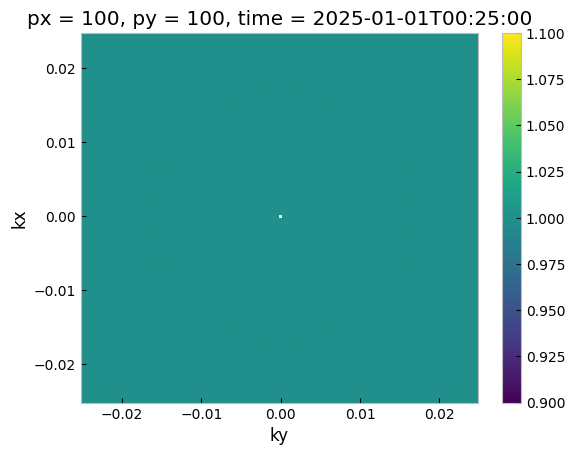

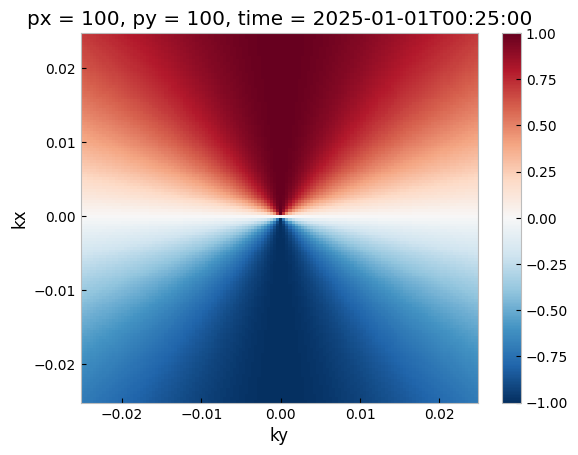

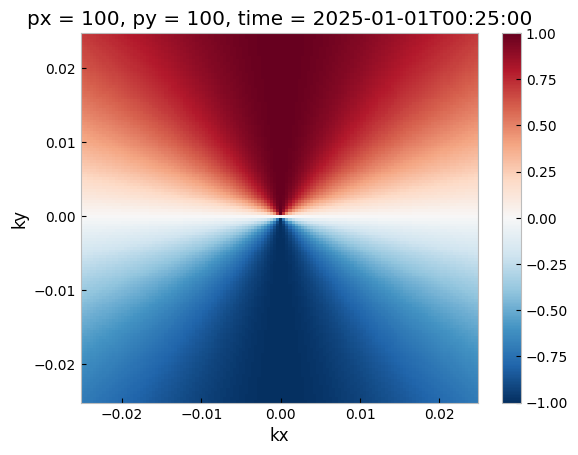

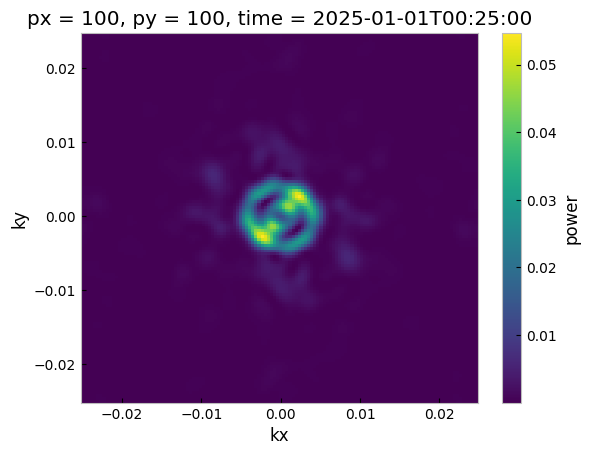

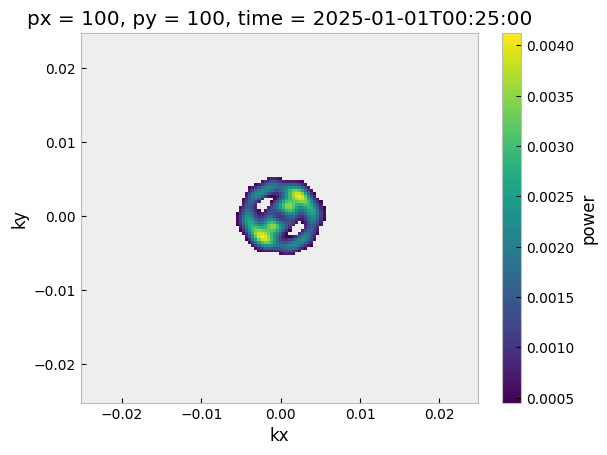

In [ ]:
# (params2.R.isel(time=25) - params.snr.isel(time=25)).plot()
# params.coherence.isel(time=25).plot(robust=True)
pwr = patches.power.isel(time=25, px=8, py=8)

pmed = pwr.median()
psig = abs(pwr - pmed).median() * 1.5
threshold = pmed + 50 * psig
mask = pwr > threshold
nsig = mask.sum()
pnoise = pwr.where(~mask).mean() * nsig
w = pwr.where(mask)
Sp = w.sum()
SNR = (Sp - pnoise) / pnoise
w = w / Sp

K = xarray.ufuncs.hypotnp.hypot(kx, ky)
uvx = (W * np.abs(kx) / K).sum(KDIMS)
uvy = (W * np.abs(ky) / K).sum(KDIMS)
coherence = np.hypot(uvx, uvy)

plt.figure()
patches.power.isel(time=25, px=8, py=8).sortby("kx").sortby("ky").plot()
plt.figure()
w.sortby("kx").sortby("ky").plot()

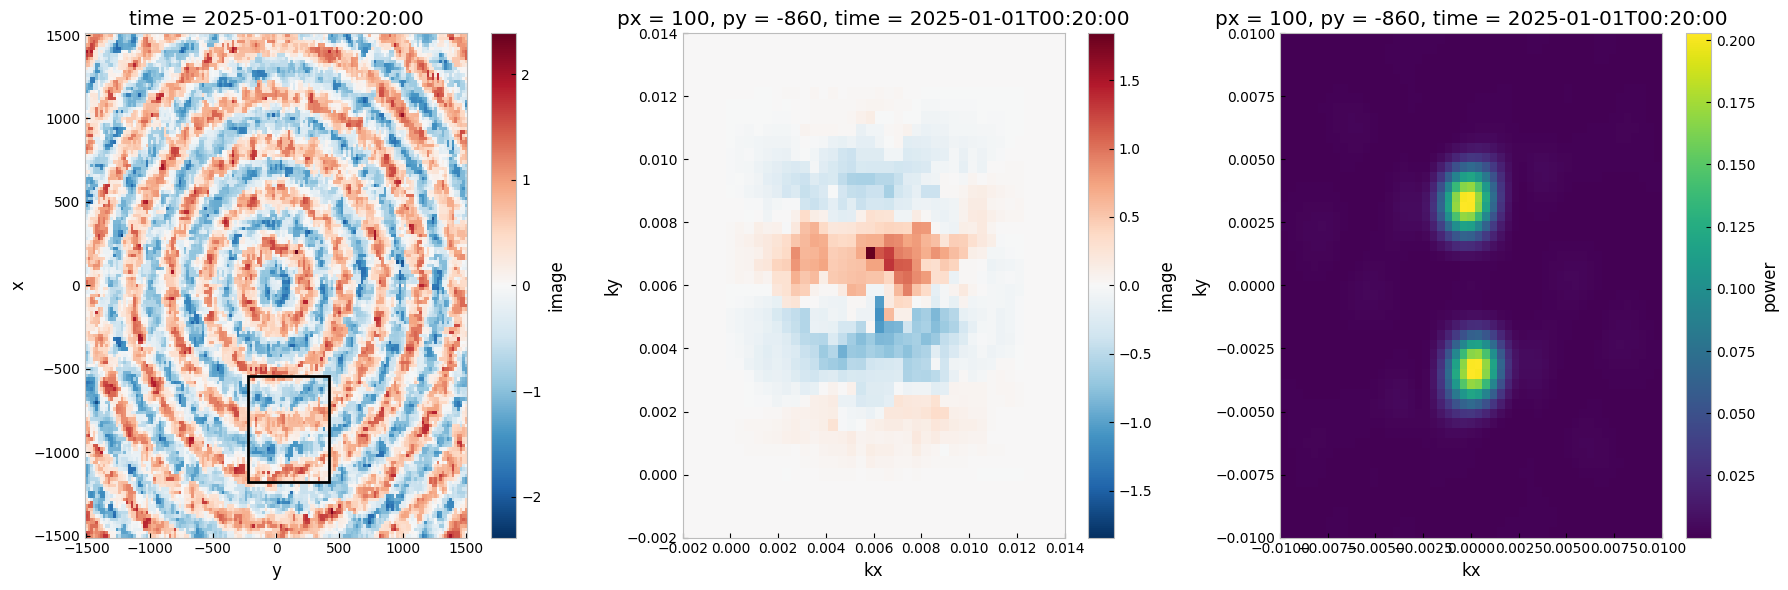

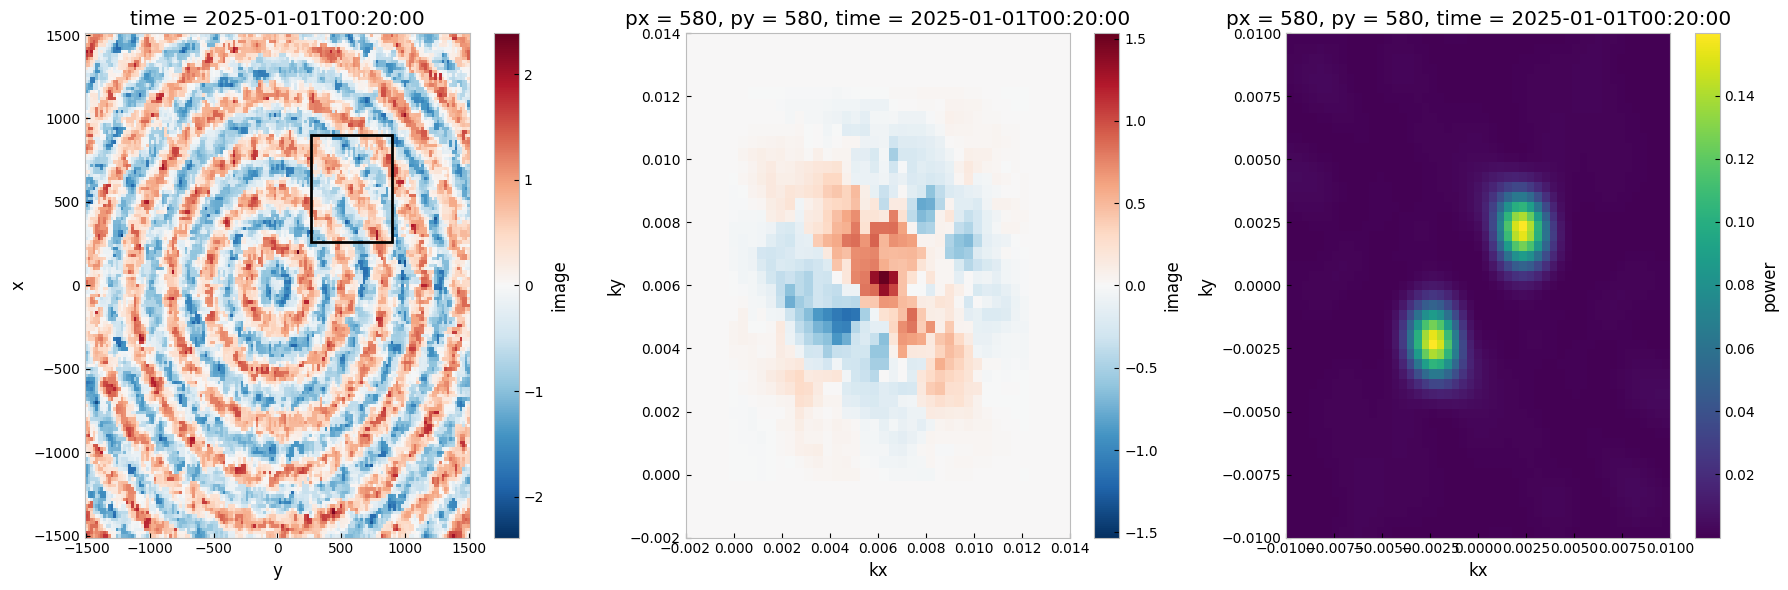

In [3]:

TI = 20
TIME = params.time[TI]

SIZE = 32 * 20
for (XI, YI) in [(8, 2), (11, 11)]:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
    data.image.sel(time=TIME).plot(ax=ax[0])
    rect = Rectangle((params.px[XI] - SIZE/2, params.py[YI] - SIZE/2), SIZE, SIZE, facecolor='none', edgecolor='black', linewidth=2)
    ax[0].add_patch(rect)
    patches.image.sel(time=TIME).isel(px=XI, py=YI).sortby("kx").sortby("ky").plot(ax=ax[1])
    ax[1].set_xlim(-.002, .014)
    ax[1].set_ylim(-.002, .014)
    patches.power.sel(time=TIME).isel(px=XI, py=YI).sortby("kx").sortby("ky").plot(ax=ax[2])
    ax[2].set_xlim(-.01, .01)
    ax[2].set_ylim(-.01, .01)

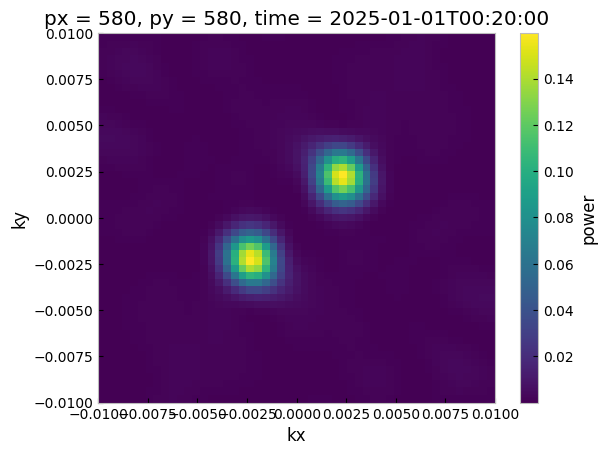

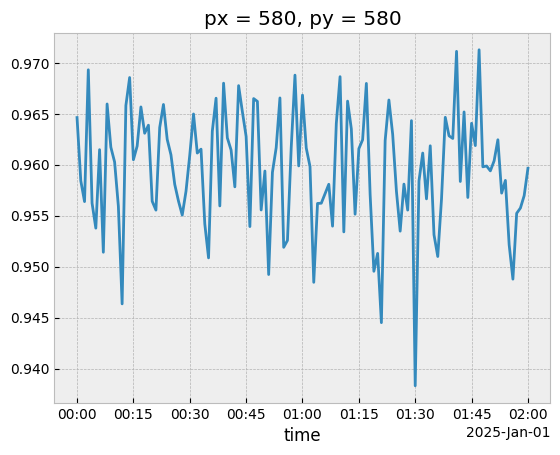

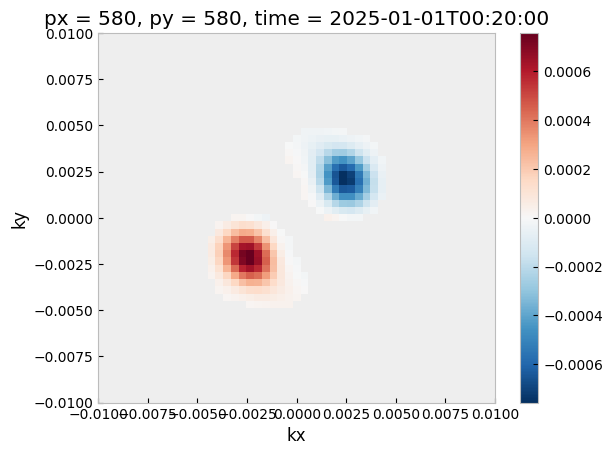

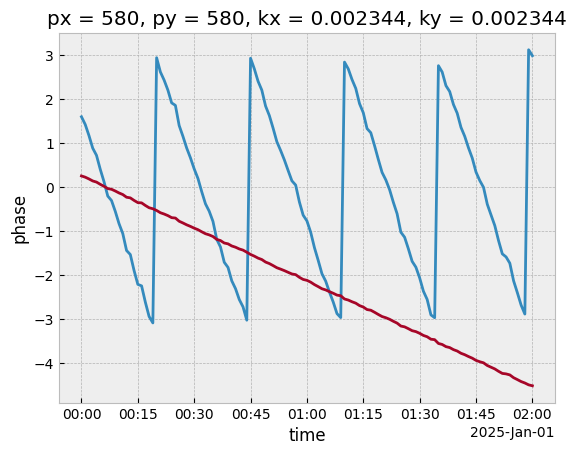

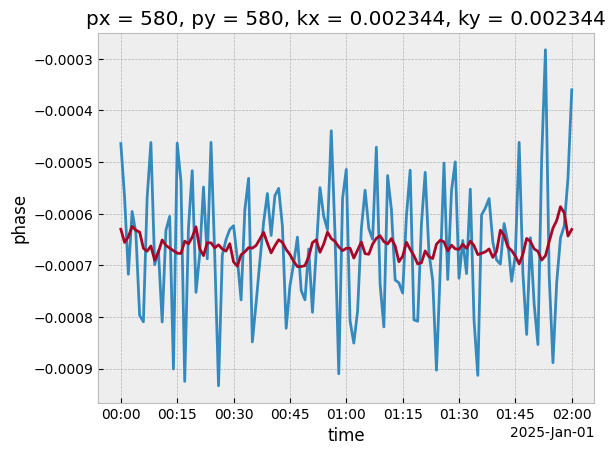

In [4]:
KDIMS = ["kx", "ky"]
phase = patches.phase.isel(px=XI, py=YI)
phase.values = np.unwrap(phase, axis=0)
f = phase.differentiate("time", datetime_unit="s")
power = patches.power.isel(px=XI, py=YI)
pmed = power.median(KDIMS)
psig = 1.4826 * abs(power - pmed).median(KDIMS)
threshold = pmed + 50 * psig

plt.figure()
power.isel(time=TI).sortby("kx").sortby("ky").plot()
plt.xlim(-.01, .01)
plt.ylim(-.01, .01)

nsig = (power > threshold).sum(KDIMS)
pnoise = power.where(power < threshold).mean(KDIMS)
power = power.where(power > threshold)
weight = power / power.sum(KDIMS)
k = np.hypot(weight.kx, weight.ky)
Rx = (weight * abs(weight.kx) / k).sum(KDIMS)
Ry = (weight * abs(weight.ky) / k).sum(KDIMS)
coherence = np.hypot(Rx, Ry)

plt.figure()
# weight.isel(time=TI).sortby("kx").sortby("ky").plot()
coherence.plot()

plt.figure()
(power * f).isel(time=TI).sortby("kx").sortby("ky").plot()
# (power).isel(time=TI).sortby("kx").sortby("ky").plot()
plt.xlim(-.01, .01)
plt.ylim(-.01, .01)


k = patches.power.isel(px=XI, py=YI).argmax(KDIMS)
k = patches.power.isel(px=XI, py=YI, **k)

plt.figure()
p = patches.phase.isel(px=XI, py=YI).sel(kx=k.kx[TI].item(), ky=k.ky[TI].item())
p.plot()
p.values = np.unwrap(p) / (2 * np.pi)
p.plot()

plt.figure()
p.differentiate("time", datetime_unit="s").plot()
p.differentiate("time", datetime_unit="s").rolling(time=11, center=True, min_periods=1).mean().plot()

(-0.015, 0.015)

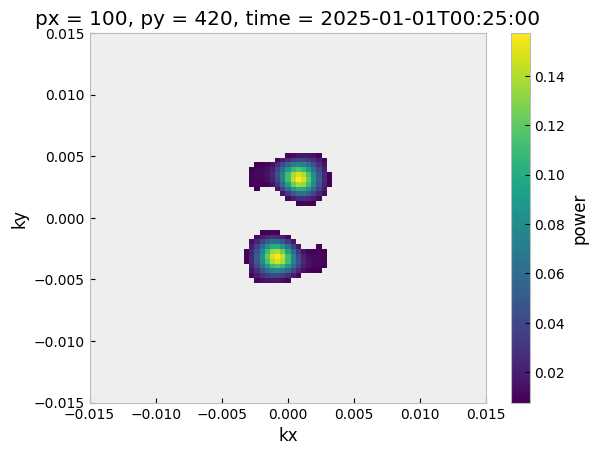

In [38]:
p = patches.power.isel(time=25)
mean, threshold, var, nnoise = gnss_tid.parameter.estimate_noise_hs74(p.values.ravel(), .2)
p.where(p > threshold).isel(px=8, py=10).sortby("kx").sortby("ky").plot()
mean, threshold, var, nnoise
plt.xlim(-.015, .015)
plt.ylim(-.015, .015)

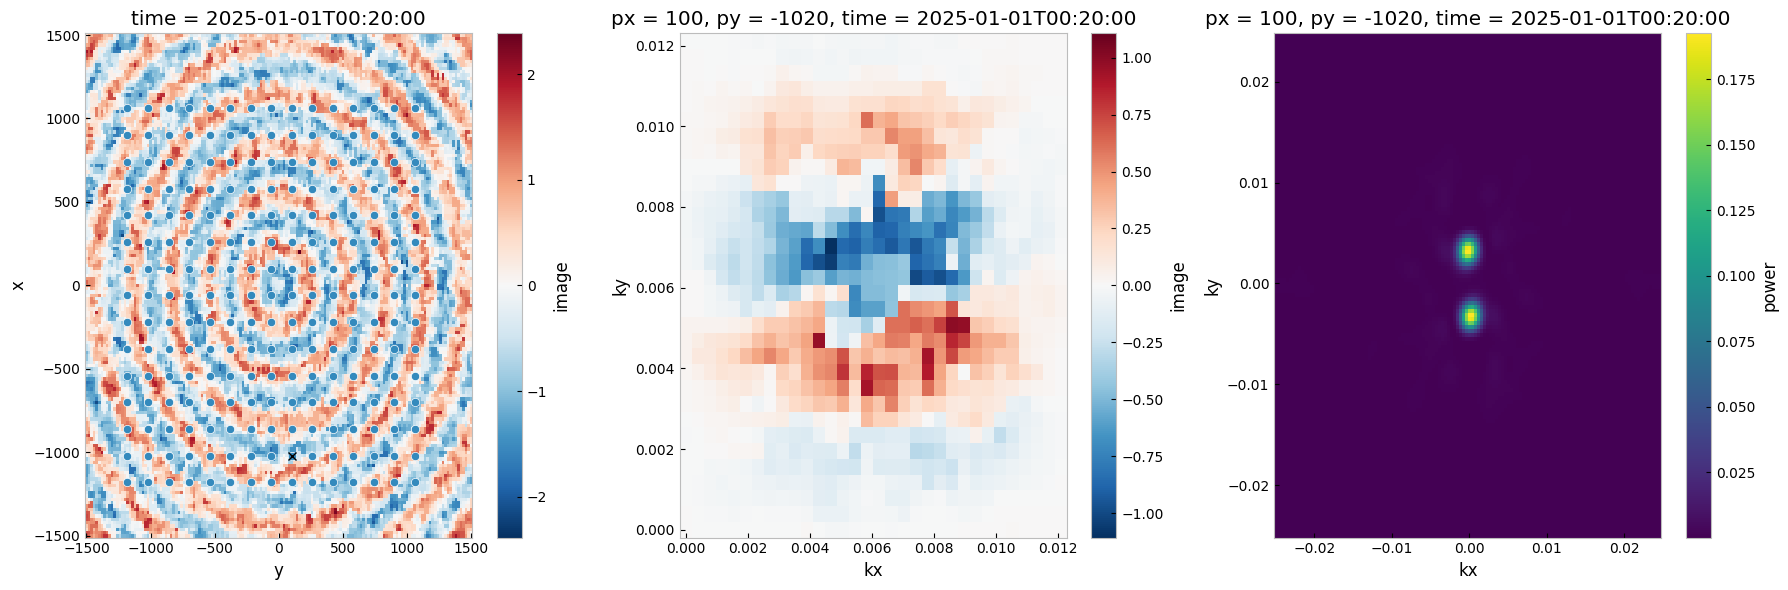

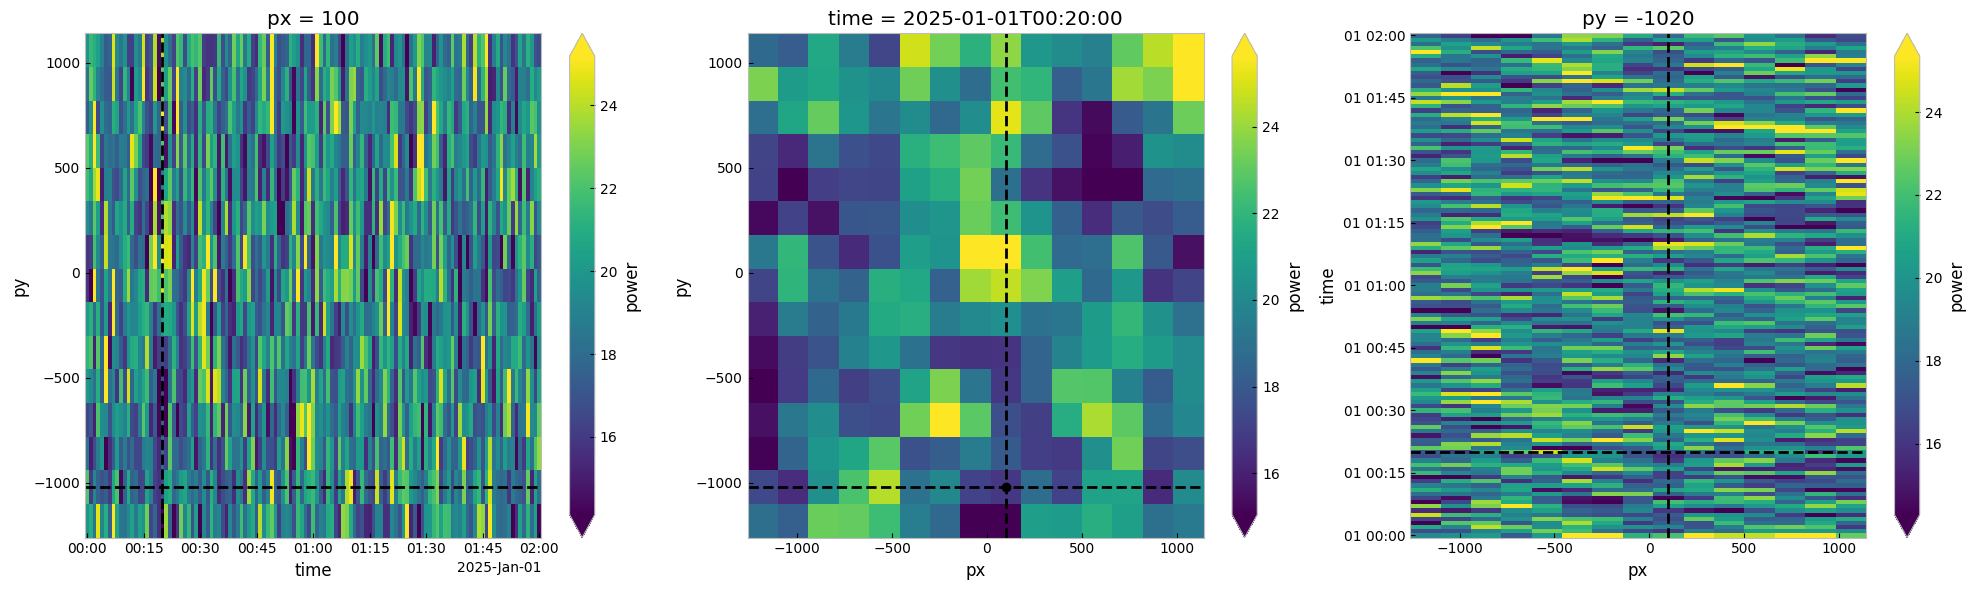

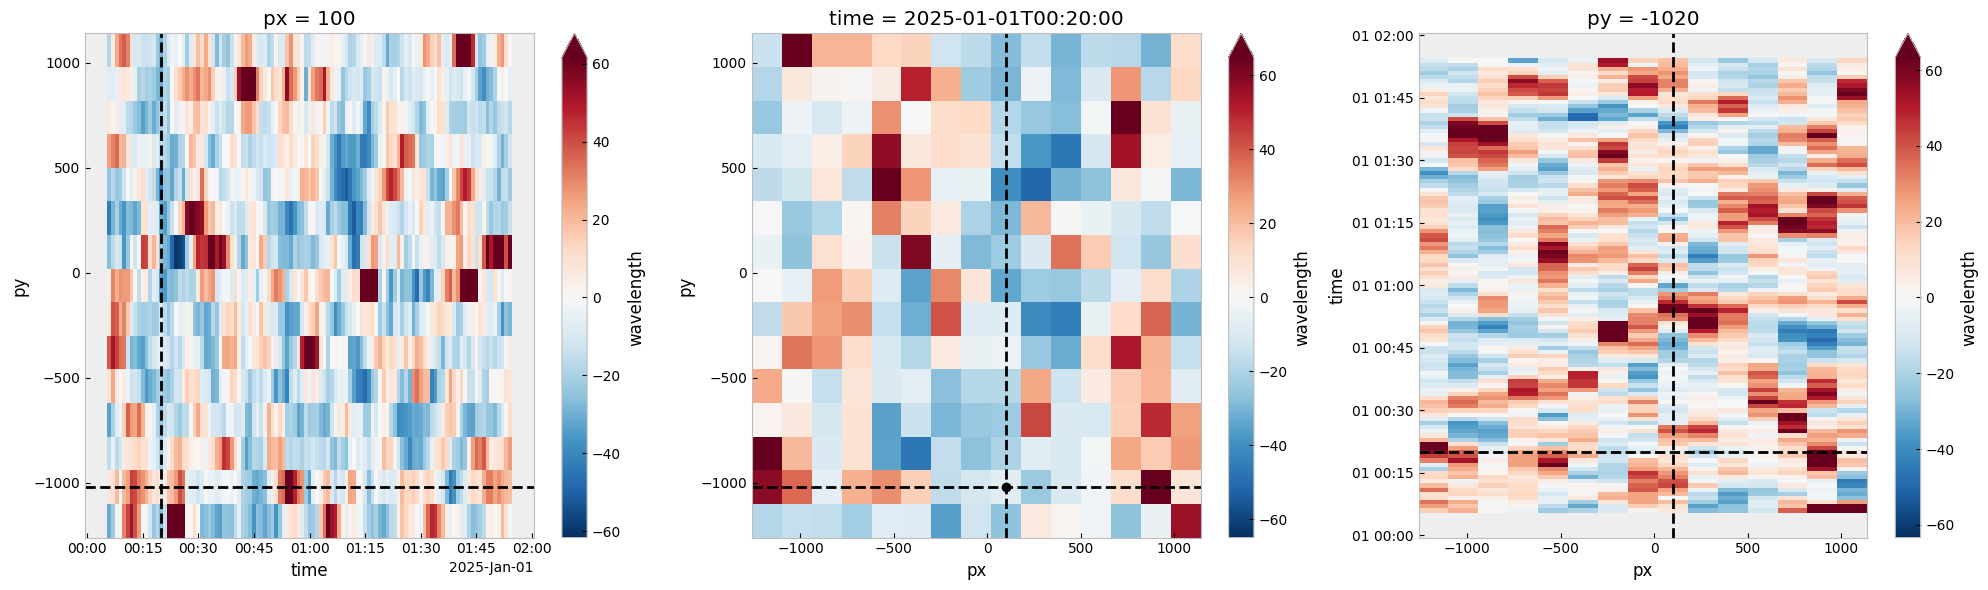

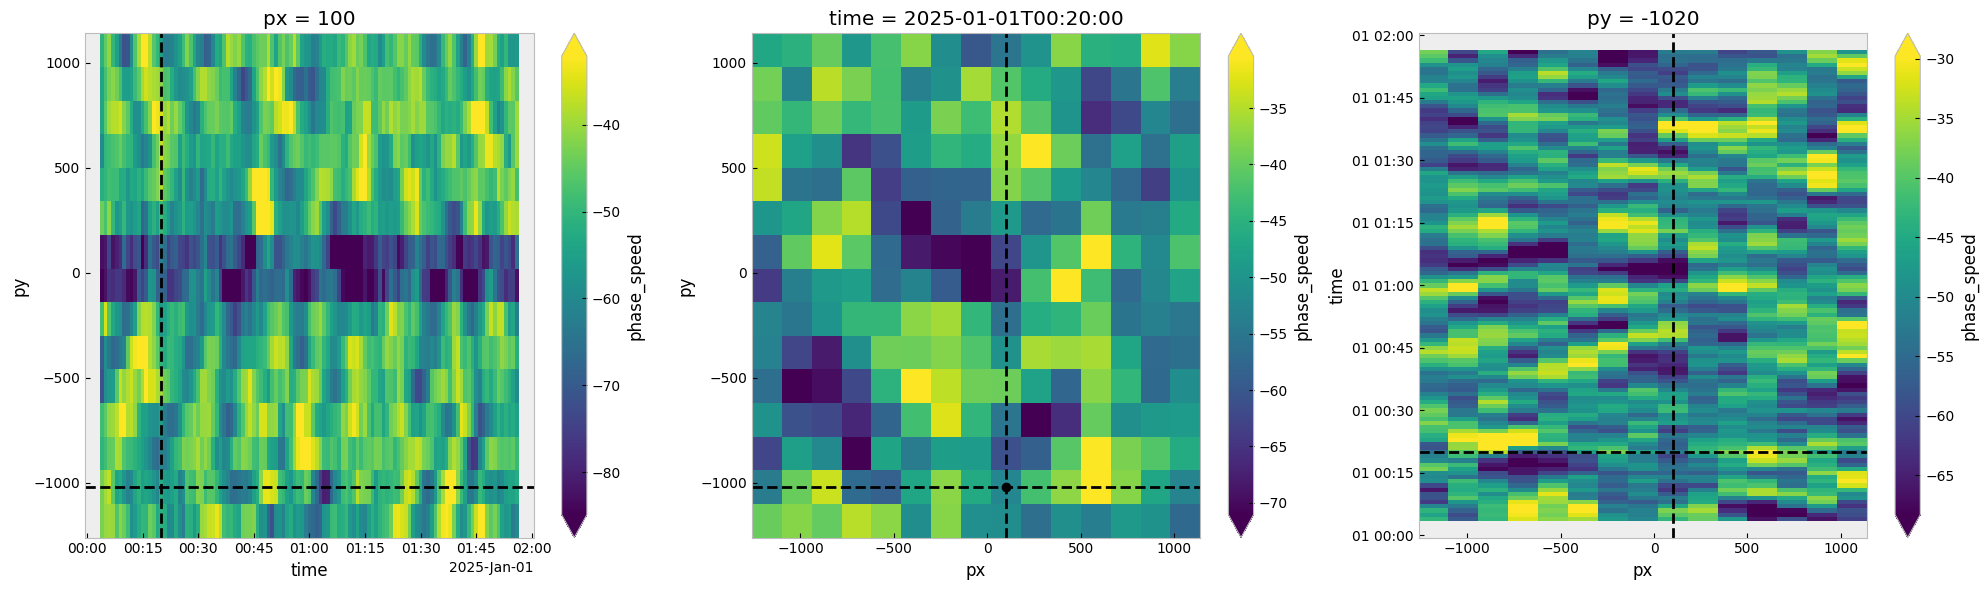

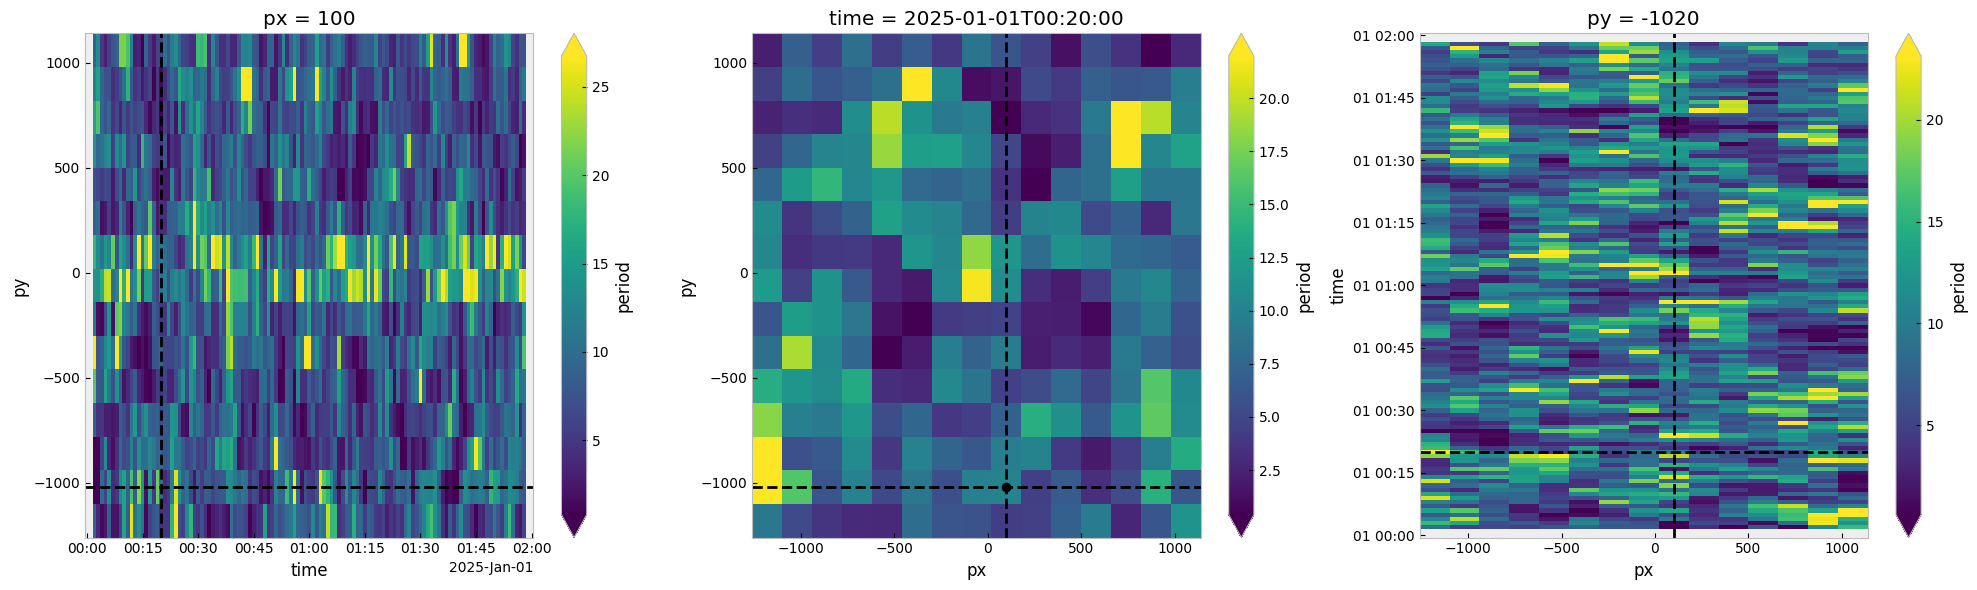

In [6]:
# PHASE PLOTS
def plot_param_3plane(name, TI, XI, YI, val):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6), tight_layout=True)
    (params[name] - val).isel(px=XI).plot(ax=ax[0], x="time", y="py", robust=True)
    ax[0].axvline(params.time[TI].values, c="k", linestyle="--")
    ax[0].axhline(params.py[YI].values, c="k", linestyle="--")
    (params[name] - val).isel(time=TI).plot(ax=ax[1], x="px", y="py", robust=True)
    ax[1].axvline(params.px[XI].values, c="k", linestyle="--")
    ax[1].axhline(params.py[YI].values, c="k", linestyle="--")
    ax[1].plot(params.px[XI].values, params.py[YI].values, 'ko')
    (params[name] - val).isel(py=YI).plot(ax=ax[2], x="px", y="time", robust=True)
    ax[2].axvline(params.px[XI].values, c="k", linestyle="--")
    ax[2].axhline(params.time[TI].values, c="k", linestyle="--")


XI = 8
YI = 1
# TI = 75
TI = 20
TIME = params.time[TI]

## PATCH
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
data.image.sel(time=TIME).plot(ax=ax[0])
params.plot.scatter(x="px", y="py", add_labels=False, ax=ax[0])
ax[0].plot(params.px[XI], params.py[YI], 'kx')
patches.image.sel(time=TIME).isel(px=XI, py=YI, kx=slice(params.block_size), ky=slice(params.block_size)).plot(ax=ax[1])
patches.power.sel(time=TIME).isel(px=XI, py=YI).sortby("kx").sortby("ky").plot(ax=ax[2])

## PARAMS
plot_param_3plane("power", TI, XI, YI, 0)
plot_param_3plane("wavelength", TI, XI, YI, wavelength)
plot_param_3plane("phase_speed", TI, XI, YI, phase_speed)
plot_param_3plane("period", TI, XI, YI, period)


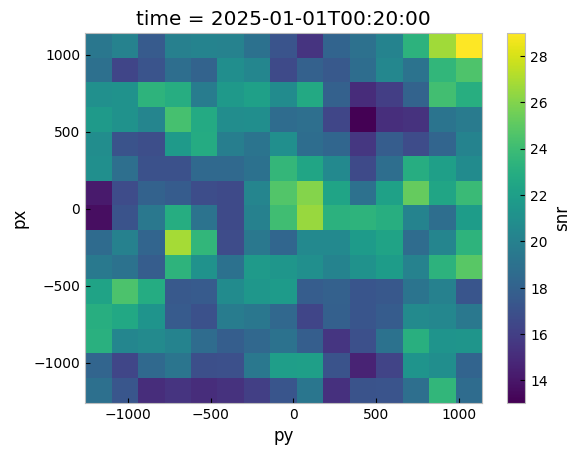

In [7]:
params.snr.isel(time=TI).plot()

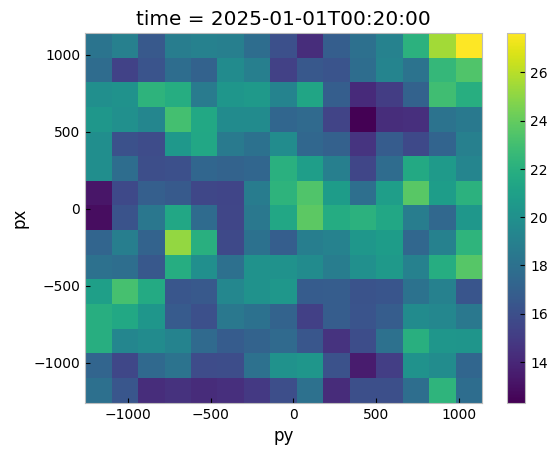

In [8]:
(params.coherence * params.snr).isel(time=TI).plot()